In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ЧТЕНИЕ ДАТАФРЕЙМА

In [2]:
dataframe_row = pd.read_csv('query_result_2022-10-03T07_36_20.3623Z.csv',
                            parse_dates=['order_created_date', 'user_created_date'], dayfirst=True)

In [3]:
dataframe_row.shape

(1463, 10)

In [4]:
dataframe_row.dtypes

order_id                       int64
order_created_date    datetime64[ns]
transaction_value              int64
commission                   float64
processing_cost              float64
promocode_cost               float64
integration_cost             float64
user_id                        int64
user_created_date     datetime64[ns]
user_region_code              object
dtype: object

In [5]:
dataframe = dataframe_row.copy()

isna_columns = dataframe.columns[dataframe.isna().any()].tolist()

dataframe[isna_columns] = dataframe[isna_columns].fillna(0)

dataframe['fixed_costs'] = dataframe.processing_cost + dataframe.integration_cost
dataframe['costs'] = dataframe.fixed_costs + dataframe.promocode_cost
dataframe['costs_share'] = dataframe.costs / dataframe.transaction_value

dataframe

,order_id,order_created_date,transaction_value,commission,processing_cost,promocode_cost,integration_cost,user_id,user_created_date,user_region_code,fixed_costs,costs,costs_share
0,1110097,2021-04-04,4721,429.611,236.0500,150.0,74.1197,121105,2021-03-09,se,310.1697,460.1697,0.097473
1,1110415,2021-04-24,6309,624.591,275.0724,100.0,120.5019,121123,2020-10-17,ua,395.5743,495.5743,0.078550
2,1110406,2021-04-16,3095,318.785,127.2045,0.0,0.0000,121123,2020-10-17,ua,127.2045,127.2045,0.041100
3,1110399,2021-04-14,2017,203.717,84.3106,100.0,49.4165,121123,2020-10-17,ua,133.7271,233.7271,0.115879
4,1110706,2021-04-09,4593,367.440,235.6209,150.0,72.1101,121144,2021-04-07,se,307.7310,457.7310,0.099658
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,1279106,2021-04-20,7410,659.490,400.8810,100.0,116.3370,131125,2021-02-04,de,517.2180,617.2180,0.083295
1459,1279493,2021-04-09,7825,821.625,340.3875,0.0,178.4100,131143,2020-10-12,it,518.7975,518.7975,0.066300
1460,1279499,2021-04-04,5472,536.256,286.7328,0.0,0.0000,131146,2021-03-13,ru,286.7328,286.7328,0.052400
1461,1279726,2021-04-13,6415,551.690,332.2970,100.0,0.0000,131156,2021-01-02,ua,332.2970,432.2970,0.067388


# РАСЧЁТ БАЗОВЫХ ПОКАЗАТЕЛЕЙ

In [6]:
purchases_base = dataframe['order_id'].count()
purchases_base

1463

In [7]:
unique_users_base = dataframe['user_id'].nunique()
unique_users_base

798

In [8]:
purchases_per_user_base = purchases_base / unique_users_base
purchases_per_user_base.round(2)

1.83

In [9]:
total_commision_base = dataframe['commission'].sum()
total_commision_base.round(2)

743570.97

In [10]:
total_value_base = dataframe['transaction_value'].sum()
total_value_base

7418722

In [11]:
margin_base = total_commision_base / total_value_base
margin_base.round(6)

0.100229

In [12]:
total_fixed_costs_base = dataframe['fixed_costs'].sum()
total_fixed_costs_base.round(2)

476007.35

In [13]:
total_marketing_costs_base = dataframe['promocode_cost'].sum()
total_marketing_costs_base

109650.0

In [14]:
total_costs_base = total_fixed_costs_base + total_marketing_costs_base
total_costs_base.round(2)

585657.35

In [15]:
total_costs_share_base = total_costs_base / total_value_base
total_costs_share_base.round(6)

0.078943

# ФИКСАЦИЯ ПАРАМЕТРОВ МОДЕЛИ

In [16]:
prize = 50000 ### билет в Дубай будет выдаваться одному случайному клиенту 
purchases_per_user_model = 10 ### наши ожидания относительно среднего кол-ва покупок на одного клиента
loyalty_cost_share_model = 0.01 ### 1% от суммы транзакции будет возвращен клиенту в рамках программы лояльности
atv_model = 3000 ### наши ожидания относительно среднего чека при покупке

# МОДЕЛИРОВАНИЕ

In [17]:
def modeling(promo = 50000, ppu = 10, lo_sha = 0.01, atv = 3000):
    """
    promo -- стоимость приза
    ppu -- наши ожидания относительно среднего
           кол-ва покупок на одного клиента
    lo_sha -- процент от суммы транзакции будет
              возвращен клиенту в рамках программы лояльности
    atv -- наши ожидания относительно среднего чека при покупке
    """
    n = 1
    profit = -1
    amt = []
    prf = []
    while profit < 0:
        income = ppu * atv * n
        revenue = income * margin_base
        loyatly = income * lo_sha
        revenue_exc_loyalty = revenue - loyatly
        revenue_exc_loyalty_and_prize = revenue - loyatly - promo
        gross_costs = income * total_costs_share_base
        operation_profit = revenue - revenue_exc_loyalty_and_prize
        profit = revenue_exc_loyalty_and_prize - gross_costs
        amt.append(n)
        prf.append(profit)
        n += 1
    
    return amt, prf

In [18]:
amt, prf = modeling(50000,10,0.01,3000)

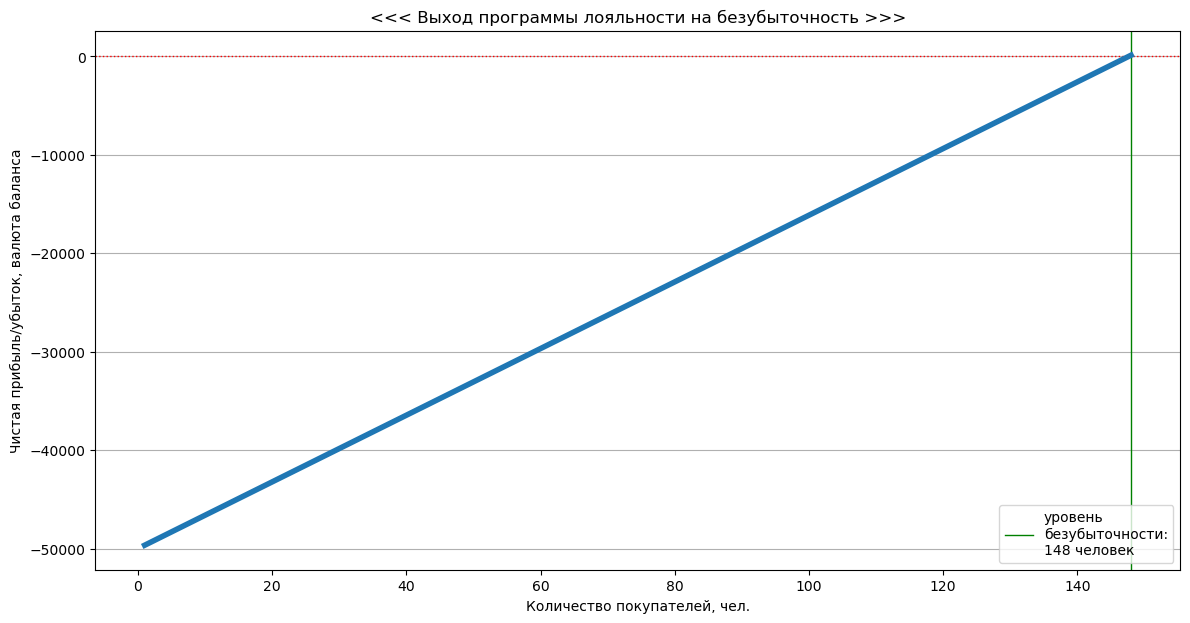

In [19]:
plt.figure(figsize=(14, 7))

plt.title('<<< Выход программы лояльности на безубыточность >>>') 
plt.xlabel('Количество покупателей, чел.') 
plt.ylabel('Чистая прибыль/убыток, валюта баланса') 

fp = amt[next(i for i, v in enumerate(prf) if v > 0)]

plt.axvline(fp, color = 'green', linestyle = '-', lw = 1, label = f"уровень\nбезубыточности:\n{str(fp)} человек")
plt.axhline(0, color = 'red', linestyle = ':', lw = 1)

plt.grid(axis='y') 
plt.plot(amt, prf, lw=4)

plt.legend(loc='lower right')

plt.savefig('fig-1-breakeven.png')

plt.show()

In [20]:
amt[0]

1

In [21]:
prf[0]

-49661.42524197564

## Разное количество заказов

In [22]:
orders = []
x = []
for order in range(1,21,1):
    amt, prf = modeling(50000, order, 0.01, 3000)
    x.append(order)
    orders.append(amt[-1])

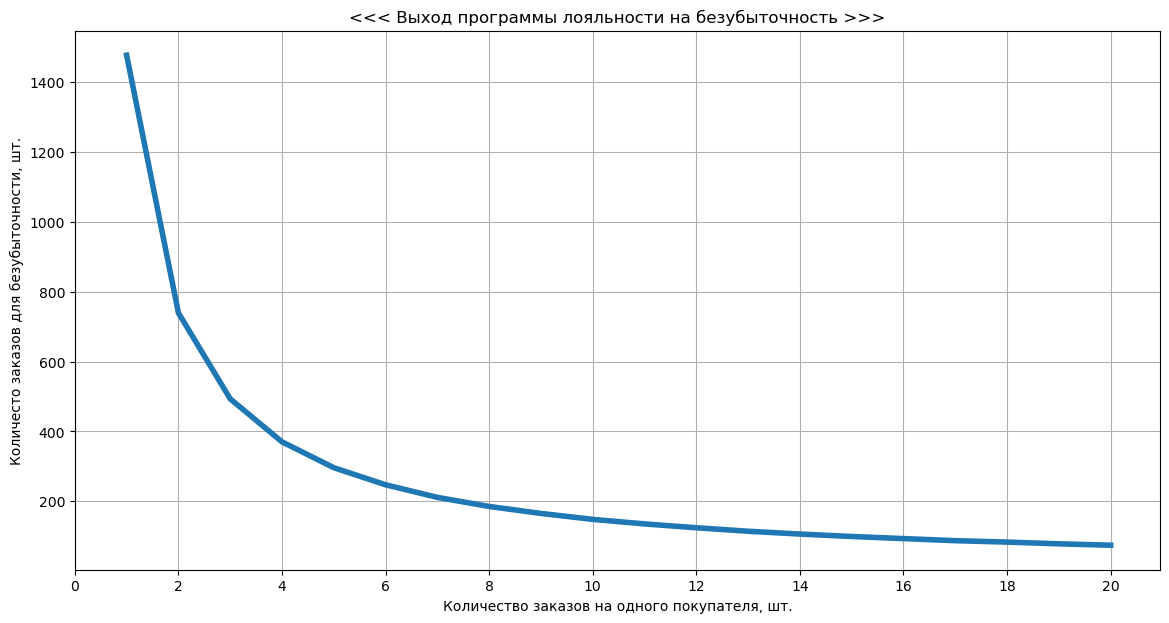

In [23]:
plt.figure(figsize=(14, 7))

plt.title('<<< Выход программы лояльности на безубыточность >>>') 
plt.xlabel('Количество заказов на одного покупателя, шт.') 
plt.ylabel('Количесто заказов для безубыточности, шт.') 

plt.plot(x, orders, lw=4)

plt.xticks(np.arange(0,21,2))

plt.grid()

plt.savefig('fig-2-orders.png')

plt.show()

## Разный процент лояльности

In [24]:
loyalties = []
x = []
for each in range(25, 185, 10):
    share = each / 10000
    amt, prf = modeling(50000, 10, share, 3000)
    x.append(share)
    loyalties.append(amt[-1])

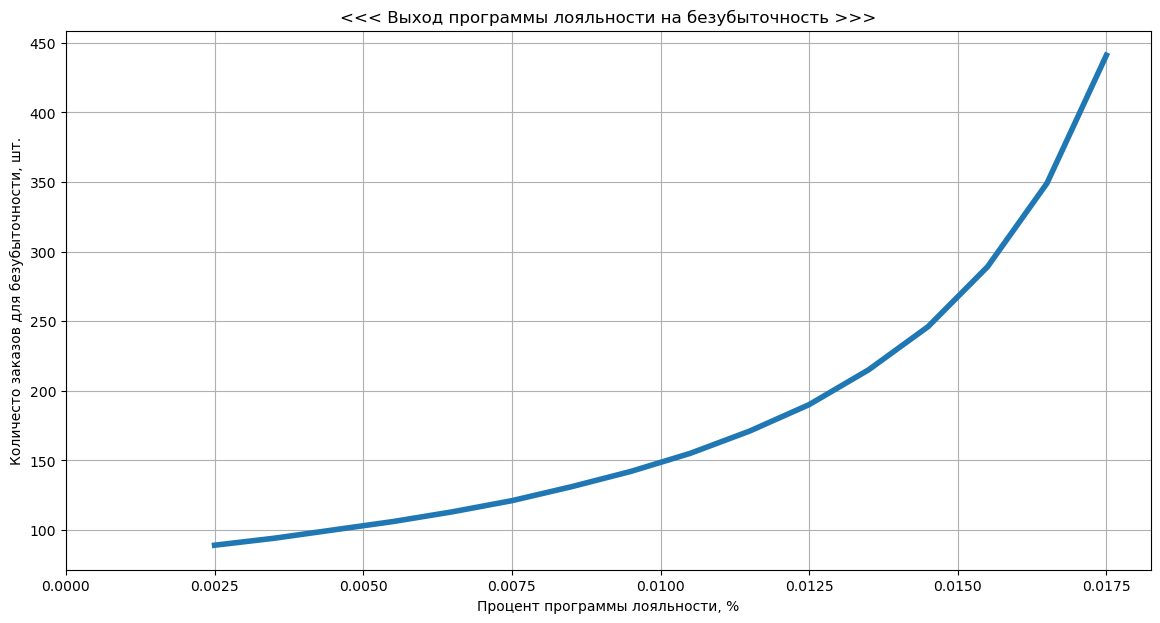

In [25]:
plt.figure(figsize=(14, 7))

plt.title('<<< Выход программы лояльности на безубыточность >>>') 
plt.xlabel('Процент программы лояльности, %') 
plt.ylabel('Количесто заказов для безубыточности, шт.') 

plt.plot(x, loyalties, lw=4)

plt.xticks(np.arange(0,0.02,0.0025))

plt.grid()

plt.savefig('fig-3-loyalties.png')

plt.show() 

## Разный средний чек

In [26]:
values = []
x = []
for tab in range(1000, 5000, 100):
    amt, prf = modeling(50000, 10, 0.01, tab)
    x.append(tab)
    values.append(amt[-1])

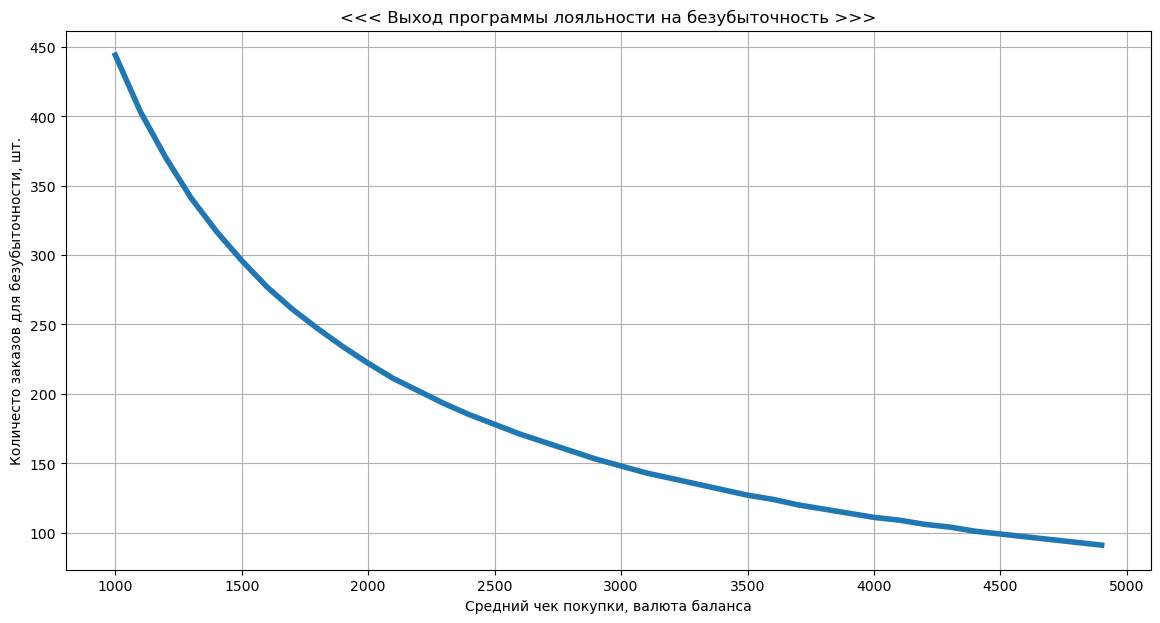

In [27]:
plt.figure(figsize=(14, 7))

plt.title('<<< Выход программы лояльности на безубыточность >>>') 
plt.xlabel('Средний чек покупки, валюта баланса') 
plt.ylabel('Количесто заказов для безубыточности, шт.') 

plt.plot(x, values, lw=4)

plt.grid()

plt.savefig('fig-4-values.png')

plt.show() 